In [1]:
%matplotlib inline
from pylab import *
rcParams['font.size'] = 15
rcParams['legend.fontsize'] = 12

# Set up paths
inputs = eval(open("../inputs.txt").read())
sys.path.insert(0, inputs['CRANE_dir']+'/02_Inference')

In [2]:
# Import Auger_Data for plotting
import Auger_Data

# import an initialize the UHE_fluence class
from Fluence import UHE_fluence
print 'Loading Lookup Table'
f = np.load(inputs['Lookup_Table'])
input_Z = f['input_Z']
input_A = f['input_A']
input_log10_E = f['input_log10_E']
input_log10_z = f['input_log10_z']
observed_log10_E = f['observed_log10_E']
observed_A = f['observed_A']
uhe_LUT = f['LUT']
fcalc = UHE_fluence(input_Z, input_A, input_log10_E, input_log10_z, observed_A, observed_log10_E, uhe_LUT)

# import the likelihood class and initialize the log posterior function
from Likelihood import UHE_likelihood
logposterior = UHE_likelihood(fcalc, ['Auger'])


Loading Lookup Table
Initializing UHE_fluence
Initializing UHE_likelihood


In [3]:
# pick a set of parameters
#parms = [norm, spectral_index, E_max, f_He, f_N, f_Si, f_Fe, source_index, z1, z2, z3]
parms = [1.33e-62,-2.2,20.0,1.11e-04,1.10e-04,1.08e-04,9.92e-02,3.0,1.87,2.66,3.01, 100.]
fluences = fcalc.fluence_model(*parms)
nuclear_fluence = np.sum(fluences[1:], axis=0)
N_model = Auger_Data.Counts_Model(nuclear_fluence[fcalc.observed_log10_E>18.8999])

lp = logposterior(parms)
print 'Model log-posterior:', lp

Model log-posterior: -48.4367589467


(18.0, 22.0)

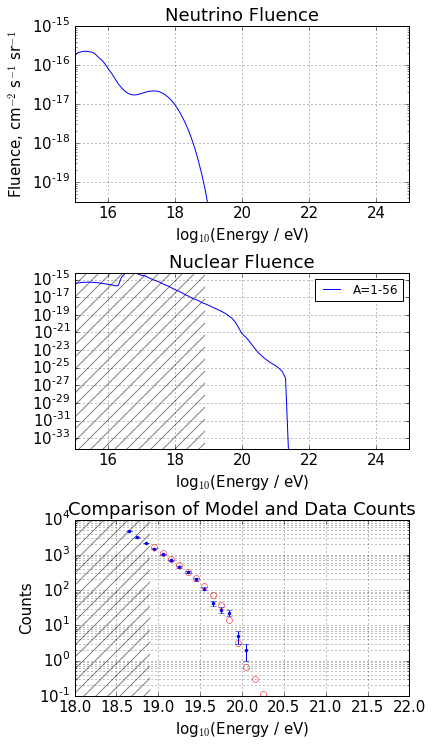

In [4]:
#print input_log10_E

figure(figsize=(6,12))
ax=subplot(311)
ax.set_yscale('log')
plot(observed_log10_E, fluences[0,:], 'b-')
ylabel('Fluence, cm$^{-2}$ s$^{-1}$ sr$^{-1}$')
xlabel('log$_{10}$(Energy / eV)')
grid(True)
title('Neutrino Fluence')
mx = np.max(fluences[0,:])
y1,y2 = ax.get_ylim()
ylim(3.e-5*y2, y2)
xlim(15., 25.)

ax2=subplot(312)
ax2.set_yscale('log')
ax2.plot(observed_log10_E, nuclear_fluence, lw=1, label='A=1-56')
mx = np.max(nuclear_fluence)
ylim(1.e-20*mx, mx)
legend()
xlim(15., 25.)
y1, y2 = ax2.get_ylim()
fill_between([15., 18.9], [y1, y1], [y2,y2], facecolor='none', hatch='//', edgecolor='gray', linewidth=0.0)
title('Nuclear Fluence')
xlabel('log$_{10}$(Energy / eV)')
subplots_adjust(hspace=0.4)
grid(True)

ax3 = subplot(313)
ax3.set_yscale('log')
from scipy.stats import poisson
p_interval =  poisson.interval(0.68, Auger_Data.Counts)
cut = Auger_Data.Counts>0.
errorbar(Auger_Data.log10_Energy_low_edges[cut] + Auger_Data.d_log10_E/2., 
         Auger_Data.Counts[cut], 
         #xerr = 0.05,
         yerr=[Auger_Data.Counts[cut]-p_interval[0][cut], p_interval[1][cut]-Auger_Data.Counts[cut]], 
         fmt='.')
ylim(0.5, 1.e4)
#xticks(np.arange(18.6, 20.2, 0.1), rotation=45)
grid(True, which='both')
ylabel('Counts')
xlabel('log10 (Energy / eV)')
title('Auger Counts by Energy Bin')
plot(fcalc.observed_log10_E[fcalc.observed_log10_E>18.8999] + 0.05, N_model, 'o', mfc='none', mec='r', label='Model')
grid(True, which='both')
y1, y2 = ax3.get_ylim()
y1=0.1
fill_between([15., 18.9], [y1, y1], [y2,y2], facecolor='none', hatch='//', edgecolor='gray', linewidth=0.0)
ylim(y1,y2)
title('Comparison of Model and Data Counts')
xlabel('log$_{10}$(Energy / eV)')
xlim(18.,22.)


In [5]:
# Example of applying minimization to improve the solution (at least locally speaking.)
# initial parameter optimization
def minus_lnprob(_parms):
    LL = logposterior(_parms)
    #'''
    print_str = '%1.2e '%LL
    for k in range(0,len(_parms)):
        print_str += '%+1.1e '%_parms[k]
    # print the values occasionally
    if(np.random.randint(0,100)==0): print print_str
    #'''
    return -1.*LL

from scipy.optimize import minimize
res = minimize(minus_lnprob, parms, method='nelder-mead', options={'xtol': 1e-3, 'disp': True})
print res
initial_parm_vals = res.x
print 'DONE MINIMIZING'


-2.83e+01 +1.3e-62 -2.2e+00 +2.0e+01 +1.1e-04 +1.1e-04 +1.1e-04 +9.8e-02 +3.0e+00 +1.9e+00 +2.7e+00 +3.0e+00 +1.0e+02 
-2.37e+01 +1.2e-62 -2.2e+00 +2.0e+01 +1.0e-04 +2.0e-05 +1.7e-04 +2.5e-01 +1.7e+00 +1.7e+00 +1.8e+00 +3.3e+00 +6.2e+01 
-2.34e+01 +1.2e-62 -2.2e+00 +2.0e+01 +1.0e-04 +6.8e-06 +1.6e-04 +2.8e-01 +1.8e+00 +1.7e+00 +1.8e+00 +3.2e+00 +5.1e+01 
-inf +1.2e-62 -2.2e+00 +2.0e+01 +1.0e-04 +9.7e-07 +1.6e-04 +2.8e-01 +1.7e+00 +1.7e+00 +1.7e+00 +3.5e+00 +5.2e+01 
-inf +1.2e-62 -2.2e+00 +2.0e+01 +1.0e-04 +4.6e-06 +1.6e-04 +2.8e-01 +1.7e+00 +1.7e+00 +1.7e+00 +3.3e+00 +5.3e+01 
-2.31e+01 +1.2e-62 -2.2e+00 +2.0e+01 +1.0e-04 +1.8e-06 +1.6e-04 +2.8e-01 +1.7e+00 +1.7e+00 +1.7e+00 +3.3e+00 +5.0e+01 
-2.25e+01 +1.1e-62 -2.2e+00 +2.0e+01 +1.0e-04 +1.5e-06 +1.7e-04 +3.8e-01 +1.1e+00 +1.6e+00 +1.8e+00 +1.8e+00 +9.5e+00 
-2.25e+01 +1.1e-62 -2.2e+00 +2.0e+01 +1.0e-04 +1.5e-06 +1.7e-04 +3.8e-01 +1.1e+00 +1.6e+00 +1.8e+00 +1.9e+00 +1.2e+01 
-2.24e+01 +1.1e-62 -2.2e+00 +2.0e+01 +1.0e-04 +3.1e-06 +1.

Maximum Likelihood Parameters
norm	1.21e-62
spectral_index	-2.24
log10_E_max	20.04
f_p	0.5867
f_He	0.0001
f_N	0.0000
f_Si	0.0001
f_Fe	0.4131
source_index	0.81
z1	1.69
z2	1.69
z3	1.69
beta	37.42
Model log-posterior: -22.1578569924


(18.0, 22.0)

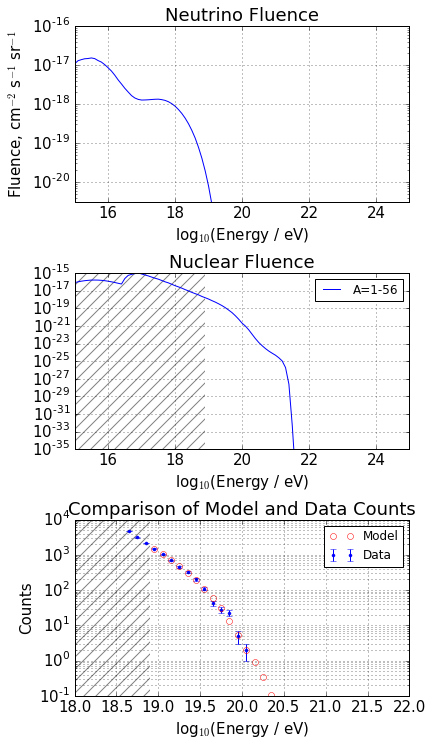

In [6]:
print 'Maximum Likelihood Parameters'
parms = res.x
print 'norm\t%1.2e'%parms[0] 
print 'spectral_index\t%1.2f'%parms[1] 
print 'log10_E_max\t%1.2f'%parms[2]
print 'f_p\t%1.4f'%(1. - np.sum(parms[3:7]))
print 'f_He\t%1.4f'%parms[3]
print 'f_N\t%1.4f'%parms[4]
print 'f_Si\t%1.4f'%parms[5]
print 'f_Fe\t%1.4f'%parms[6]
print 'source_index\t%1.2f'%parms[7]
print 'z1\t%1.2f'%parms[8]
print 'z2\t%1.2f'%parms[9]
print 'z3\t%1.2f'%parms[10]
print 'beta\t%1.2f'%parms[11]
fluences = fcalc.fluence_model(*parms)
nuclear_fluence = np.sum(fluences[1:], axis=0)
N_model = Auger_Data.Counts_Model(nuclear_fluence[fcalc.observed_log10_E>18.8999])

lp = logposterior(res.x)
print 'Model log-posterior:', lp

#print input_log10_E

figure(figsize=(6,12))
ax=subplot(311)
ax.set_yscale('log')
plot(observed_log10_E, fluences[0,:], 'b-')
ylabel('Fluence, cm$^{-2}$ s$^{-1}$ sr$^{-1}$')
xlabel('log$_{10}$(Energy / eV)')
grid(True)
title('Neutrino Fluence')
mx = np.max(fluences[0,:])
y1,y2 = ax.get_ylim()
ylim(3.e-5*y2, y2)
xlim(15., 25.)

ax2=subplot(312)
ax2.set_yscale('log')
ax2.plot(observed_log10_E, nuclear_fluence, lw=1, label='A=1-56')
mx = np.max(nuclear_fluence)
ylim(1.e-20*mx, mx)
legend()
xlim(15., 25.)
y1, y2 = ax2.get_ylim()
fill_between([15., 18.9], [y1, y1], [y2,y2], facecolor='none', hatch='//', edgecolor='gray', linewidth=0.0)
title('Nuclear Fluence')
xlabel('log$_{10}$(Energy / eV)')
subplots_adjust(hspace=0.4)
grid(True)

ax3 = subplot(313)
ax3.set_yscale('log')
from scipy.stats import poisson
p_interval =  poisson.interval(0.68, Auger_Data.Counts)
cut = Auger_Data.Counts>0.
errorbar(Auger_Data.log10_Energy_low_edges[cut] + Auger_Data.d_log10_E/2., 
         Auger_Data.Counts[cut], 
         #xerr = 0.05,
         yerr=[Auger_Data.Counts[cut]-p_interval[0][cut], p_interval[1][cut]-Auger_Data.Counts[cut]], 
         fmt='.',
         label='Data')
ylim(0.5, 1.e4)
#xticks(np.arange(18.6, 20.2, 0.1), rotation=45)
grid(True, which='both')
ylabel('Counts')
xlabel('log10 (Energy / eV)')
title('Auger Counts by Energy Bin')
plot(fcalc.observed_log10_E[fcalc.observed_log10_E>18.8999] + 0.05, N_model, 'o', mfc='none', mec='r', label='Model')
grid(True, which='both')
y1, y2 = ax3.get_ylim()
y1=0.1
fill_between([15., 18.9], [y1, y1], [y2,y2], facecolor='none', hatch='//', edgecolor='gray', linewidth=0.0)
ylim(y1,y2)
title('Comparison of Model and Data Counts')
xlabel('log$_{10}$(Energy / eV)')
legend()
xlim(18.,22.)

